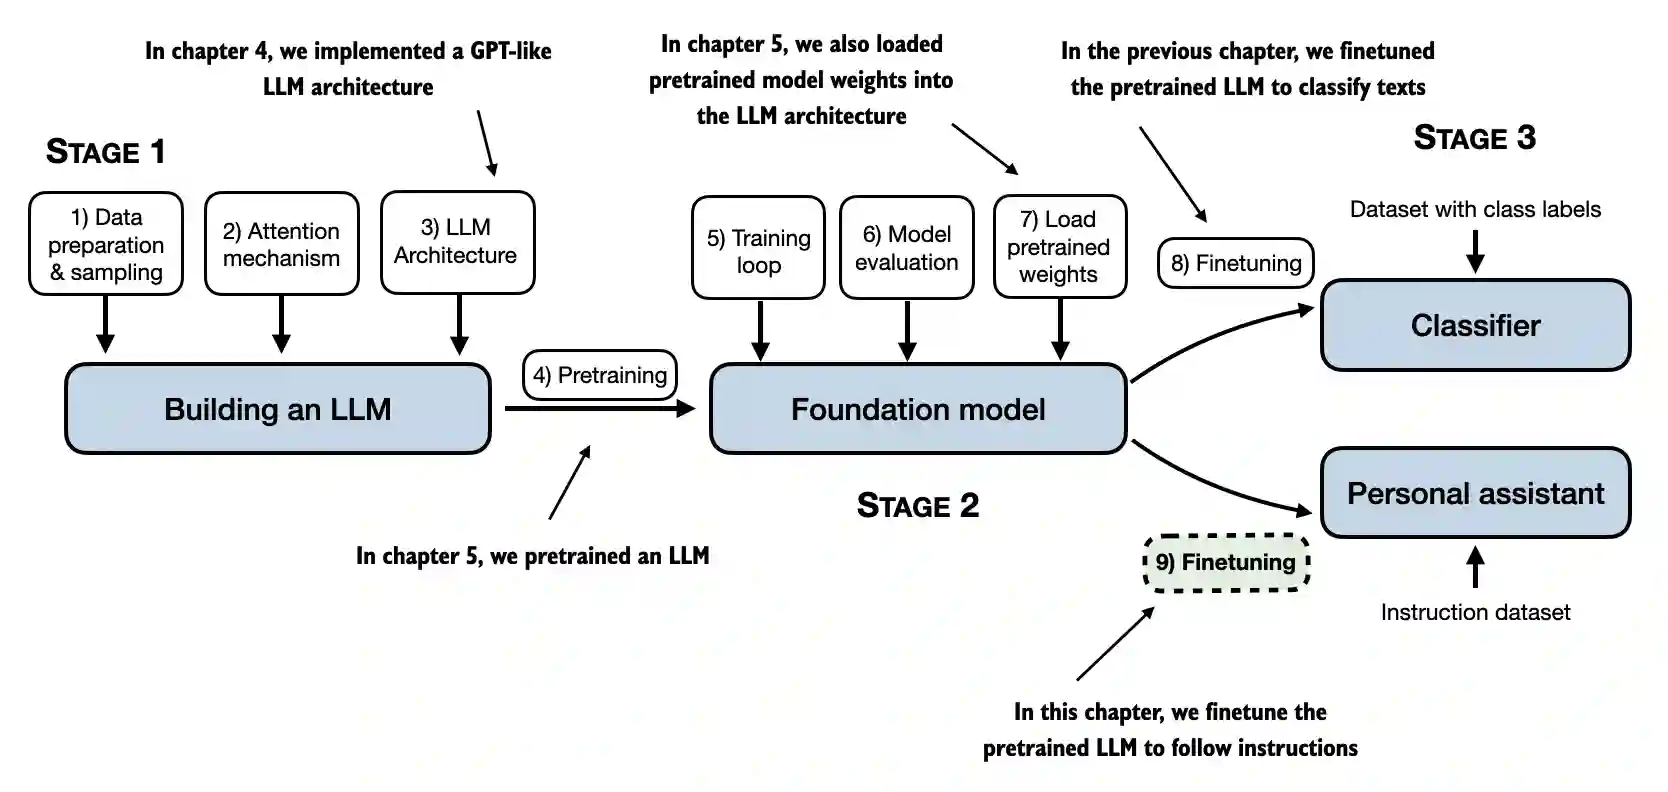

# Instruction Finetuning

## DataPreparation 

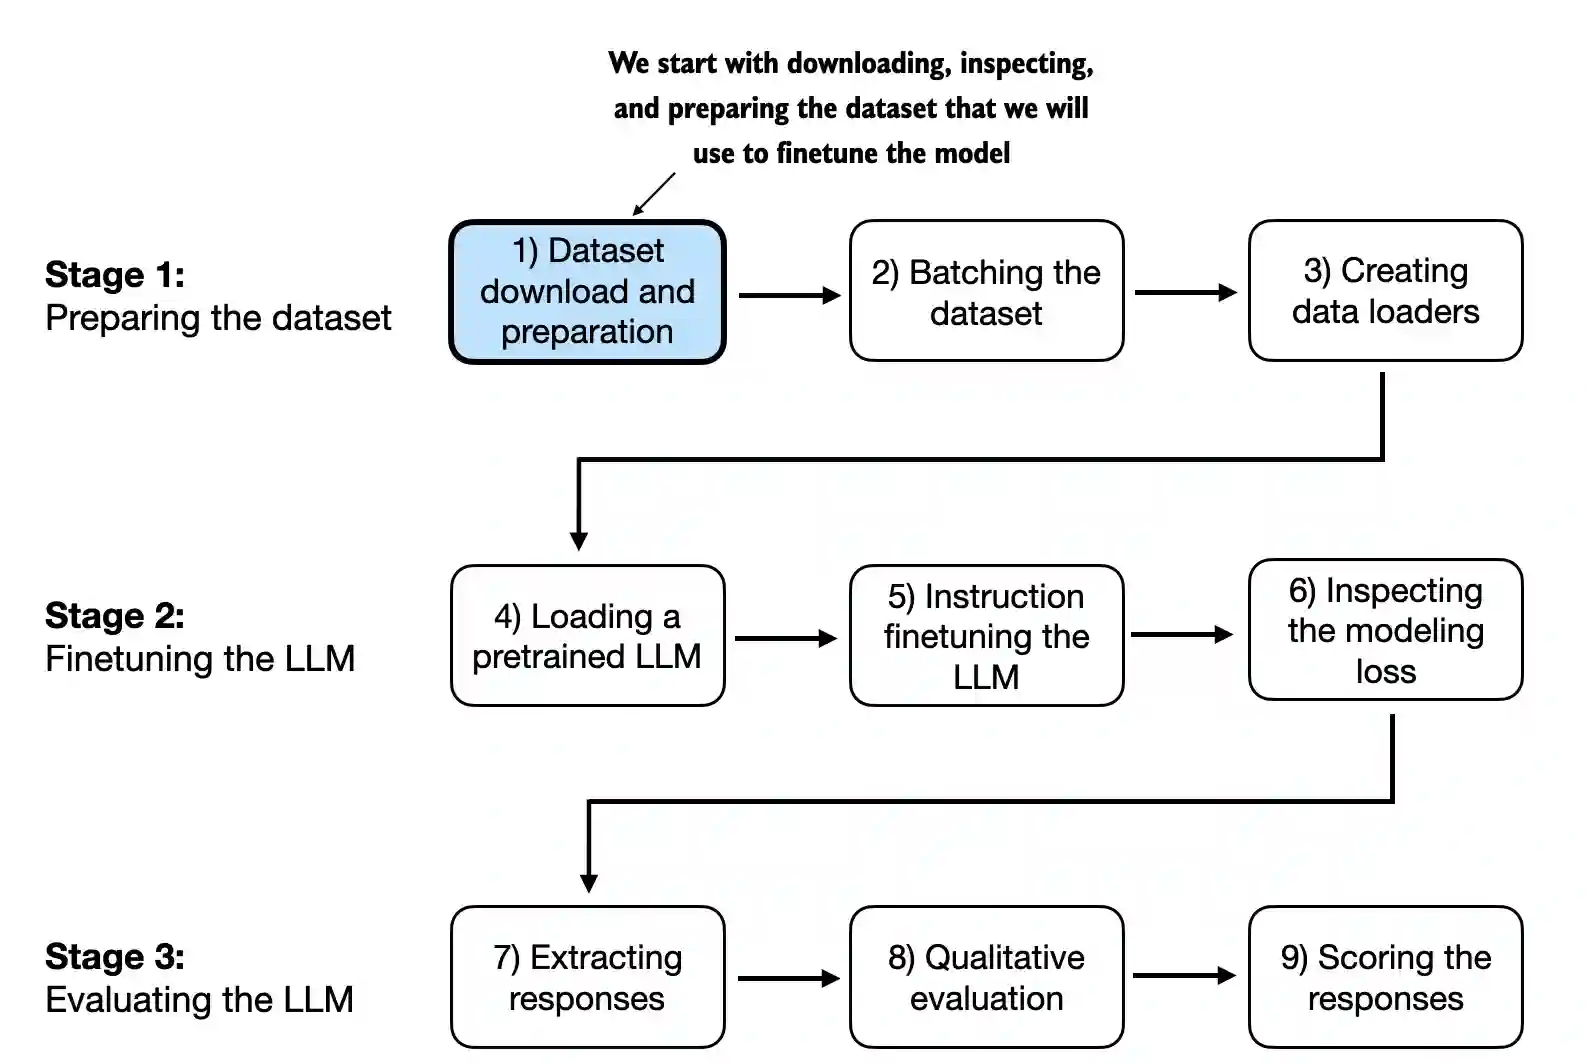

In [2]:
import json
import os
import urllib
import urllib.request

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode('utf-8')
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    
    with open(file_path, "r", encoding='utf-8') as file:
        data = json.load(file)
        return data
    
file_path = "data/instraction_data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)   

data = download_and_load_file(file_path, url)

print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
file_path = "data/alpaca_data.json"

url = (
    "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/refs/heads/main/alpaca_data.json"
)

data = download_and_load_file(file_path, url)

print(len(data))

52002


In [4]:
print(data[:5])

[{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}, {'instruction': 'What are the three primary colors?', 'input': '', 'output': 'The three primary colors are red, blue, and yellow.'}, {'instruction': 'Describe the structure of an atom.', 'input': '', 'output': 'An atom is made up of a nucleus, which contains protons and neutrons, surrounded by electrons that travel in orbits around the nucleus. The protons and neutrons have a positive charge, while the electrons have a negative charge, resulting in an overall neutral atom. The number of each particle determines the atomic number and the type of atom.'}, {'instruction': 'How can we reduce air pollution?', 'input': '', 'output': 'There are a number of ways to reduce air pollution, such as shifting to ren

In [5]:
print(data[50])

{'instruction': 'Edit the following sentence to make it more concise.', 'input': 'He ran to the bus stop in order to catch the bus that was due to arrive in five minutes.', 'output': 'He ran to the bus stop, due to arrive in five minutes.'}


In [6]:
print(data[999])

{'instruction': 'Describe the flavor profile of the following type of cuisine', 'input': 'Japanese', 'output': 'Japanese cuisine is characterized by its subtle and delicate flavors, featuring a combination of salty, sweet, sour, and umami flavors. It also utilizes fresh ingredients with a focus on preserving their natural flavors.'}


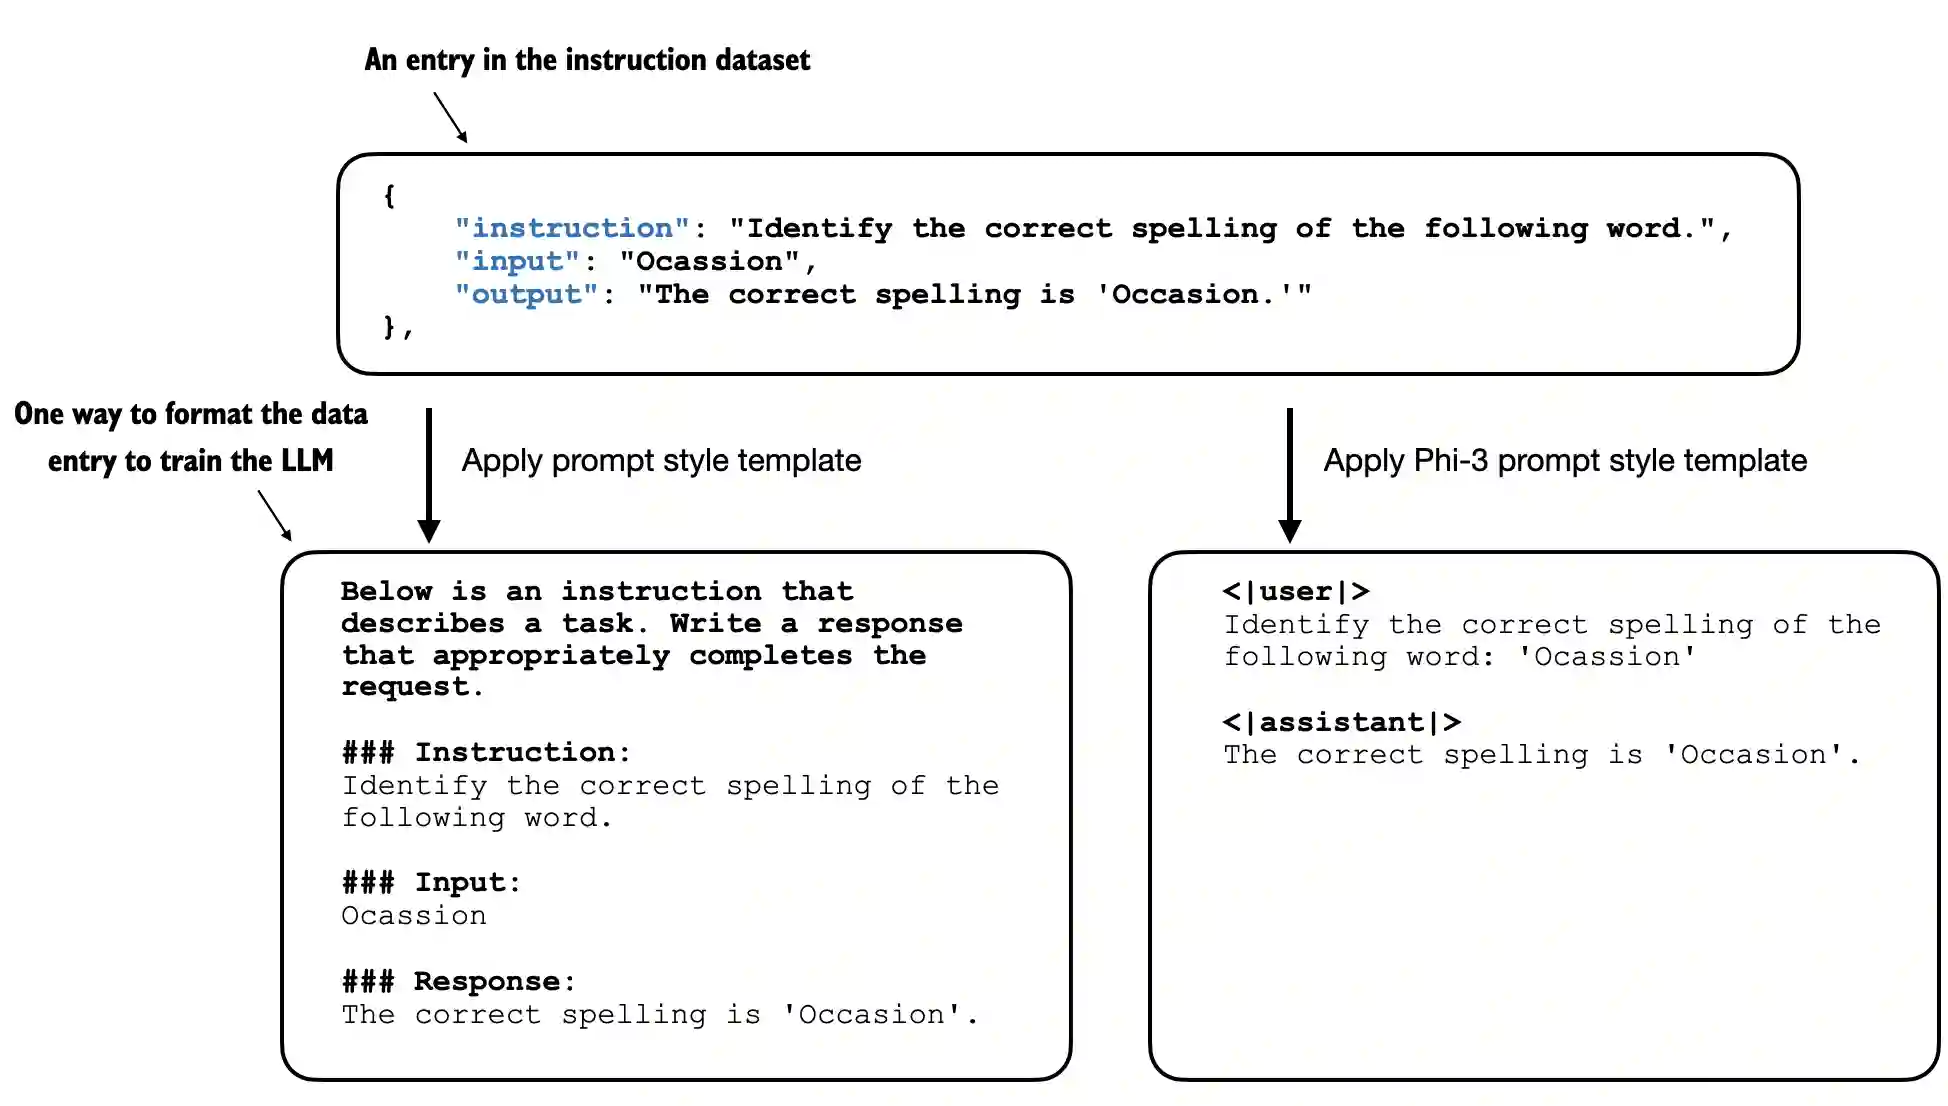

Phi-3：input和instruction是在一起的

Alpaca：则是分开的

## Batching the dataset

In [7]:
# 将一个包含指令和输入的字典条目格式化为一个结构化文本。输出不在这里操作

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""

    return instruction_text + input_text

**世界-事实-思想-句子**

In [8]:
model_input = format_input(data[999])
desire_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desire_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe the flavor profile of the following type of cuisine

### Input:
Japanese

### Response:
Japanese cuisine is characterized by its subtle and delicate flavors, featuring a combination of salty, sweet, sour, and umami flavors. It also utilizes fresh ingredients with a focus on preserving their natural flavors.


In [9]:
print(data[999])

{'instruction': 'Describe the flavor profile of the following type of cuisine', 'input': 'Japanese', 'output': 'Japanese cuisine is characterized by its subtle and delicate flavors, featuring a combination of salty, sweet, sour, and umami flavors. It also utilizes fresh ingredients with a focus on preserving their natural flavors.'}


In [10]:
train_portion = int(len(data) * 0.8)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion: train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Val:", len(val_data))
print("Train:", len(train_data))
print("Test:", len(test_data))

Val: 5201
Train: 41601
Test: 5200


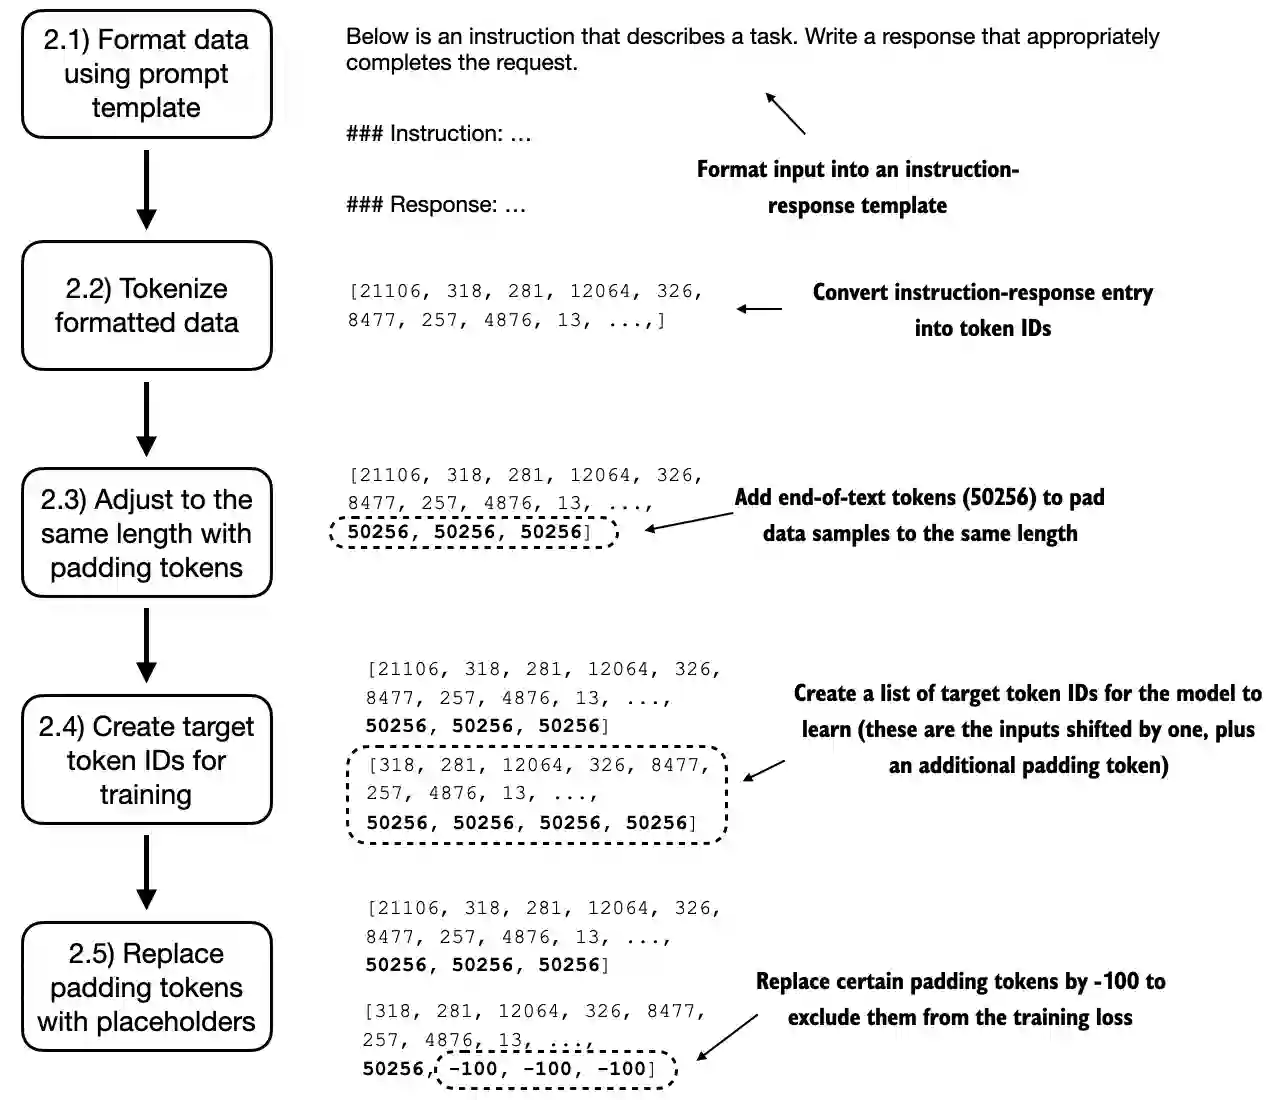

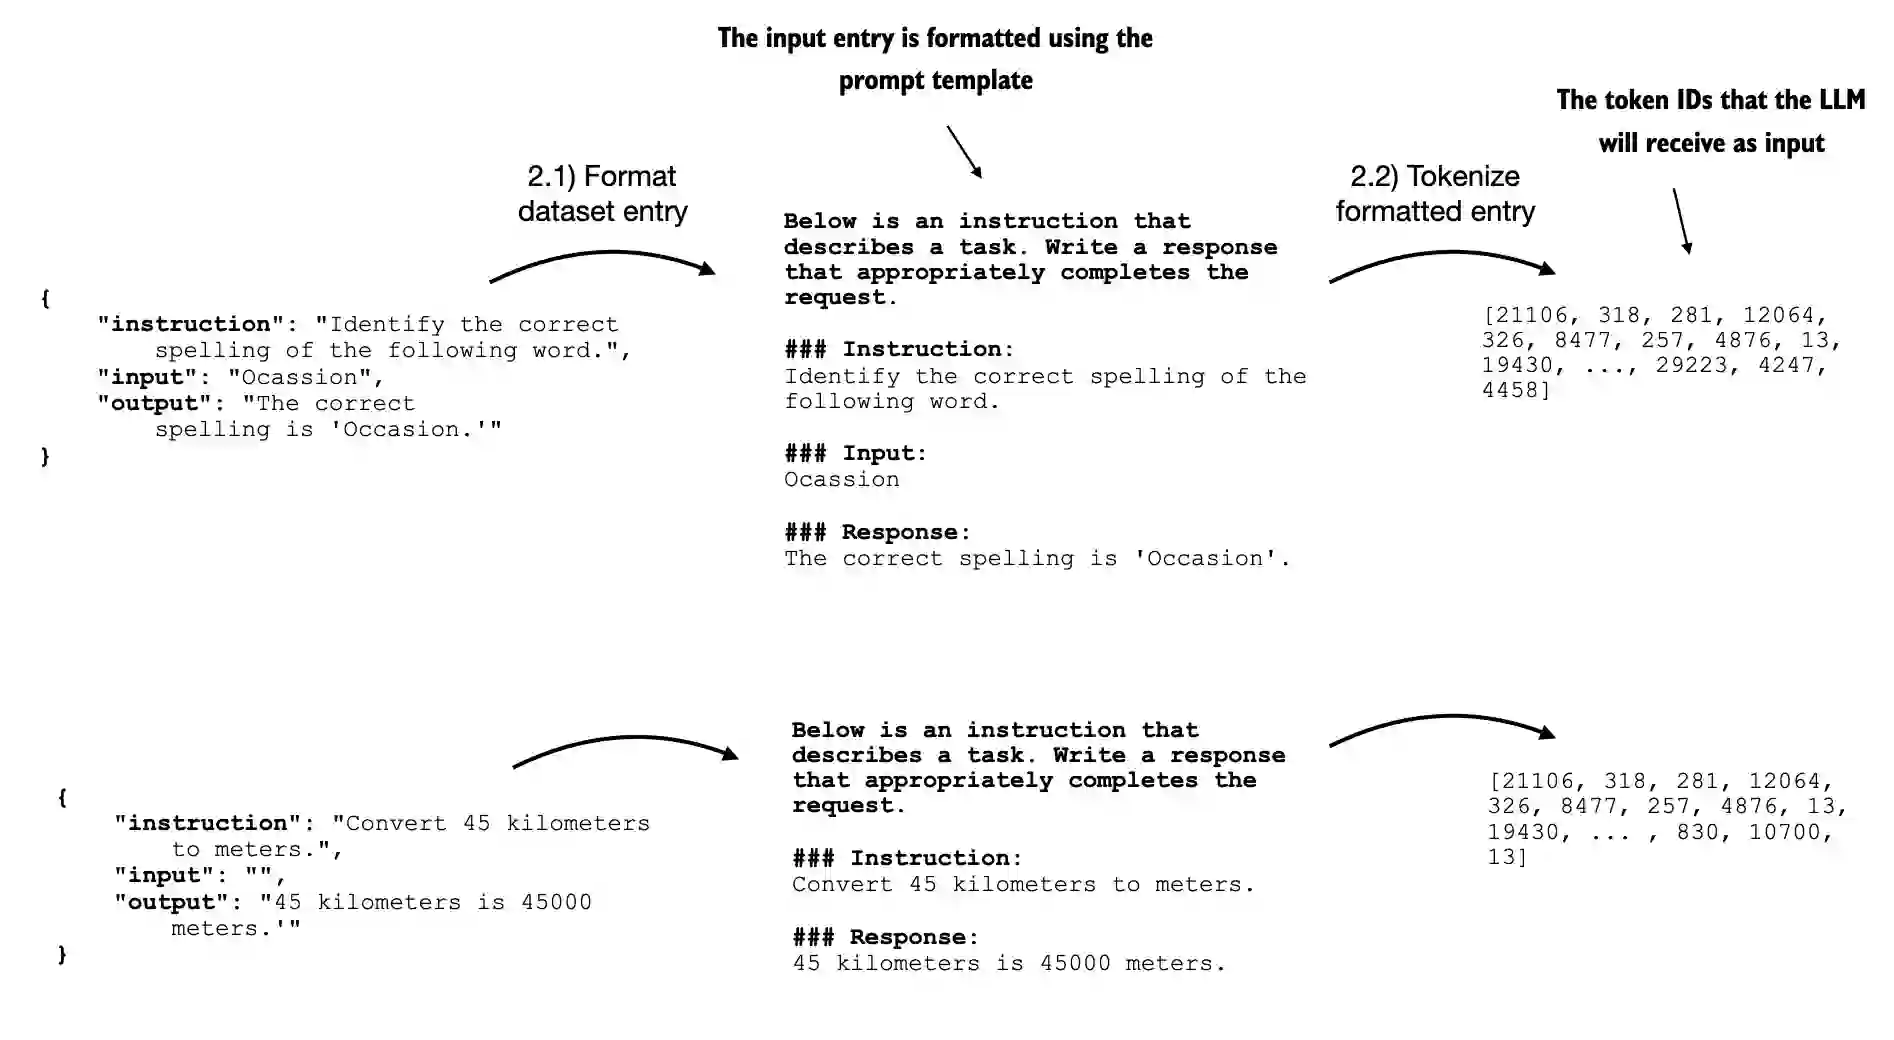

<div class="alert alert-block alert-info">
<b>Step 1:</b> Truncate the last token for inputs

<b>Step 2:</b> Shift +1 to the right for targets
</div>

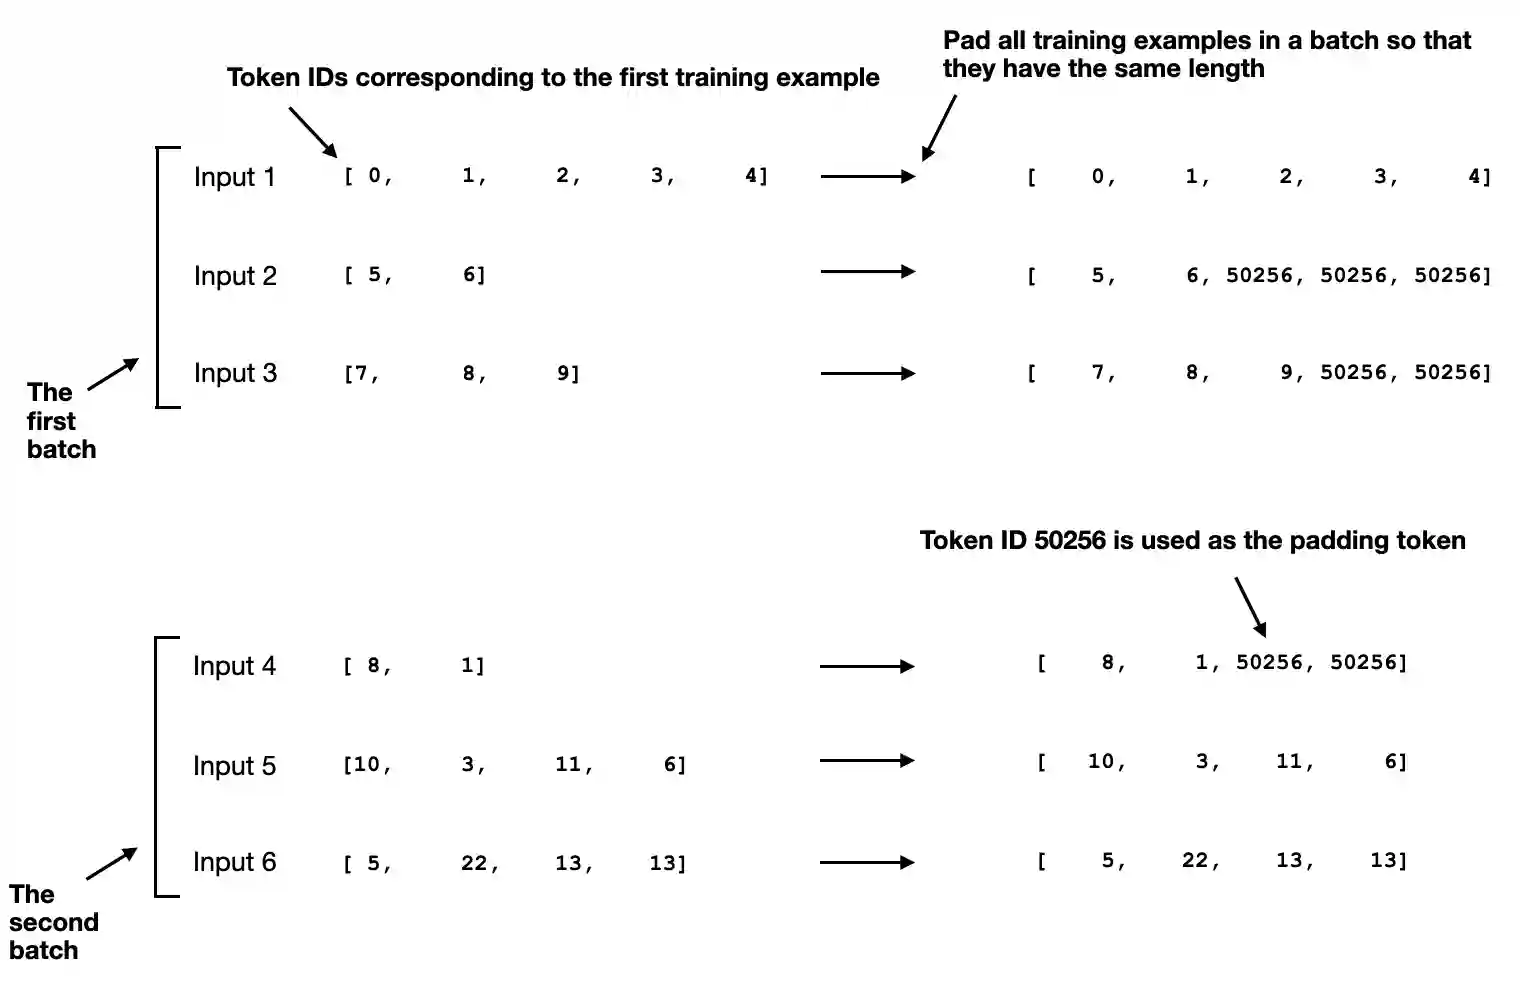

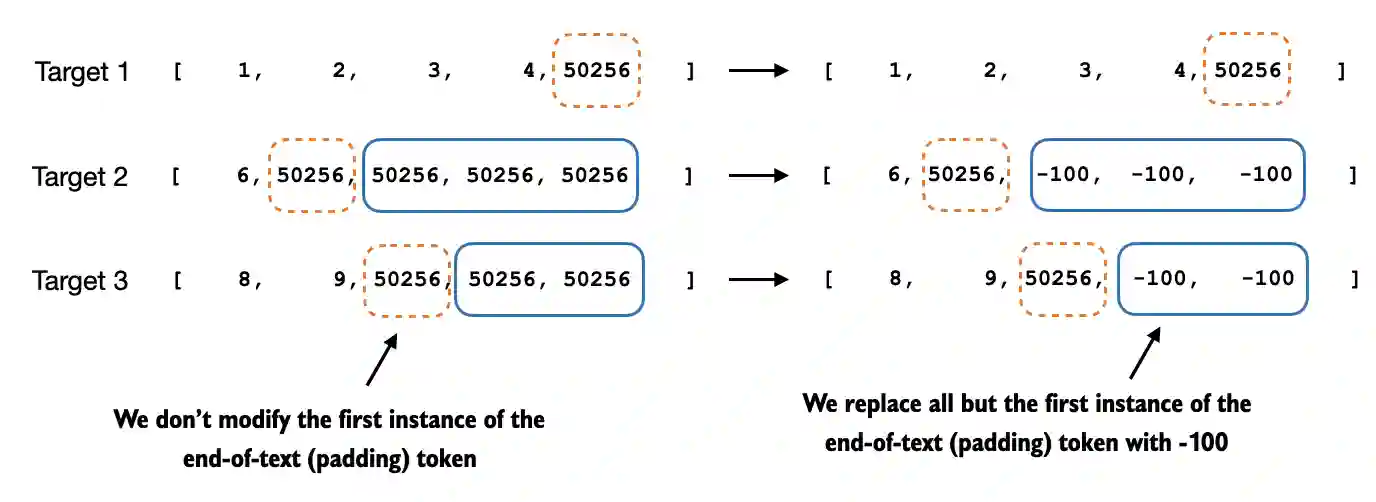

In [11]:
import torch 
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text =  f"\n\n### Response:\n{entry['output']}"
            full_text= instruction_plus_input + response_text

            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
        
    def __getitem__(self, index):
            return self.encoded_texts[index]

    def __len__(self):
            return len(self.data)


In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

end_token = tokenizer.decode([50256])
print(end_token)

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

<|endoftext|>
[50256]


In [13]:
def custom_collate_draft_1(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch) # 手动加一<|endoftext|>

    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item)) 
        )
        
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # torch.stack()将多个张量合并成一个批量，增加维度
    # torch.cat()将多个张量合并成一个张量

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor


In [14]:
input_1 = [0,1,2,3,4]
input_2 = [5,6]
input_3 = [7, 8, 9]

batch = (
    input_1,
    input_2,
    input_3
)

print(custom_collate_draft_1(batch)) 

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [15]:
def custom_collate_drafe_2(
        batch,
        pad_token_id=50256,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch) 
    # 手动加一<|endoftext|>, 需要shift

    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item)) 
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # torch.stack()将多个张量合并成一个批量，增加维度
    # torch.cat()将多个张量合并成一个张量

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_drafe_2(batch) 
print("Inputs:\n",inputs)
print("Targets:\n",targets)

Inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [17]:
def custom_collate_drafe_fn(
        batch,
        pad_token_id=50256,
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch) 
    # 手动加一<|endoftext|>, 需要shift

    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item)) 
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)

        mask = (targets == pad_token_id) # mask是一个bool张量        
        indices = torch.nonzero(mask).squeeze() # 返回非0值索引

        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
    # torch.stack()将多个张量合并成一个批量，增加维度
    # torch.cat()将多个张量合并成一个张量

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [18]:
inputs, targets = custom_collate_drafe_fn(batch) 
print("Inputs:\n",inputs)
print("Targets:\n",targets)

Inputs:
 tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
Targets:
 tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [19]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [20]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [21]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [22]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

print(device)

cpu


In [23]:
from functools import partial
custom_collate_drafe_fn = partial(custom_collate_drafe_fn, device=device, allowed_max_length=1024) # 固定了两个参数

## Create DataLoader

In [24]:
from torch.utils.data import DataLoader
import tiktoken

num_workers = min(12, os.cpu_count()//4) # 改用cpu的多线程
batch_size = 8

tokenizer = tiktoken.get_encoding('gpt2')
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate_drafe_fn,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=custom_collate_drafe_fn,
    drop_last=True
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=custom_collate_drafe_fn,
    drop_last=True
)

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 213]) torch.Size([8, 213])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 171]) torch.Size([8, 171])
torch.Size([8, 173]) torch.Size([8, 173])
torch.Size([8, 405]) torch.Size([8, 405])
torch.Size([8, 249]) torch.Size([8, 249])
torch.Size([8, 223]) torch.Size([8, 223])
torch.Size([8, 175]) torch.Size([8, 175])
torch.Size([8, 182]) torch.Size([8, 182])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 144]) torch.Size([8, 144])
torch.Size([8, 187]) torch.Size([8, 187])
torch.Size([8, 364]) torch.Size([8, 364])
torch.Size([8, 236]) torch.Size([8, 236])
torch.Size([8, 284]) torch.Size([8, 284])
torch.Size([8, 270]) torch.Size([8, 270])
torch.Size([8, 624]) torch.Size([8, 624])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 135]) torch.Size([8, 135])
torch.Size([8, 155]) torch.Size([8, 155])
torch.Size([8, 341]) torch.Size([8, 341])
torch.Size([8, 126]) torch.Size([8, 126])
torch.Size([8, 113])

In [26]:
#XXX 355M参数的GPT
CHOOSE_MODEL = "gpt2-medium (355M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
#     f"Dataset length {train_dataset.max_length} exceeds model's context "
#     f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
#     f"`max_length={BASE_CONFIG['context_length']}`"
# )

In [27]:
import tensorflow as tsf
import tqdm
from GPT import GPTModel
from GPT import load_weights_into_gpt
from gpt_download3 import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2025-03-20 22:07:03.499040: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 22:07:03.508624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742479623.517288    8421 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742479623.519923    8421 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742479623.526438    8421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

File already exists and is up-to-date: gpt2/124M/checkpoint


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/encoder.json


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/hparams.json


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.index


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.meta


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(i

In [28]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
For the given list of items, classify them into two categories.

### Input:
Carrot, Apple, Pumpkin, Orange


In [29]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [30]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)

response_text = (
    generated_text[len(input_text):]
    .strip()
)


print(response_text)


, Banana, Chocolate, Strawberry, Strawberry, Orange, Banana, Chocolate, Strawberry, Orange, Banana, Chocolate, Strawberry,


## Calc loss

In [31]:
def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = eval_model(
                    model, train_loader, val_loader, device, eval_iter
                )

                print(f"Ep {epoch+1} (Step{global_step:06d}):"
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

            
                
        generate_and_print_sampel(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    # [(batch_size × context_size), emb_dim] [(batch_size × context_size)]
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader)==0:
        return float('nan')
    elif num_batches is None:
        num_batches =  len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break
    
    return total_loss / num_batches

# 在loader上eval
def eval_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()

    return train_loss, val_loss

def generate_and_print_sampel(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, encoded,
                    max_new_tokens=50,
                    context_size=context_size
                    )
    decode_text = token_ids_to_text(token_ids, tokenizer)
    print(decode_text.replace("\n", " ")) # Compact print format
    model.train()

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:context_size]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx


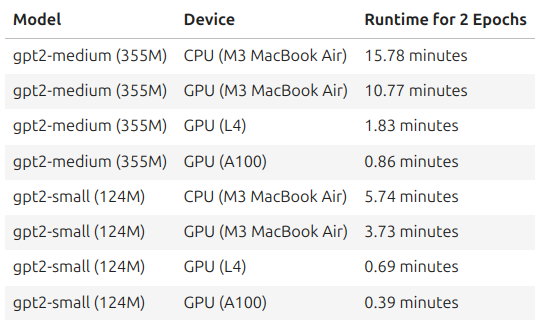

In [32]:
print(next(model.parameters()).device)

model.to(device)


cpu


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiheadAttention(
        (W_query): Linear(i

<div class="alert alert-block alert-danger">
<b>Try for OOM:</b>

1. 缩小batch_size

2. 减小context_length，1025-->256：Failed，gpt的d_in要和d_out一致，small--256，medium--1024

3. 改为班精度：Float32-->Float16 Failed！！！！ token_emb和pos_emb嵌入时溢出了。

4. 改用CPU，用内存不用显存了，优化：num_worker=min(12, os.cpu_count()//4)，Half Success（残胜）

</div>

In [32]:
# print(next(model.parameters()).dtype)
# model = model.half()
# print(next(model.parameters()).dtype)  

In [33]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ep 1 (Step000000):Train loss 2.497, Val loss 2.595
Ep 1 (Step000005):Train loss 1.047, Val loss 1.092
Ep 1 (Step000010):Train loss 0.890, Val loss 0.988
Ep 1 (Step000015):Train loss 0.842, Val loss 0.855
Ep 1 (Step000020):Train loss 0.734, Val loss 0.863
Ep 1 (Step000025):Train loss 0.792, Val loss 0.785
Ep 1 (Step000030):Train loss 0.793, Val loss 0.729
Ep 1 (Step000035):Train loss 0.641, Val loss 0.881
Ep 1 (Step000040):Train loss 0.606, Val loss 0.737
Ep 1 (Step000045):Train loss 0.631, Val loss 0.696
Ep 1 (Step000050):Train loss 0.621, Val loss 0.783
Ep 1 (Step000055):Train loss 0.643, Val loss 0.700
Ep 1 (Step000060):Train loss 0.658, Val loss 0.726
Ep 1 (Step000065):Train loss 0.593, Val loss 0.767
Ep 1 (Step000070):Train loss 0.584, Val loss 0.723
Ep 1 (Step000075):Train loss 0.512, Val loss 0.724
Ep 1 (Step000080):Train loss 0.545, Val loss 0.693
Ep 1 (Step000085):Train loss 0.559, Val loss 0.712
Ep 1 (Step000090):Train loss 0.509, Val loss 0.740
Ep 1 (Step000095):Train loss 0.

In [34]:
print(train_losses)
print(val_losses)

[tensor(2.4975), tensor(1.0472), tensor(0.8904), tensor(0.8419), tensor(0.7345), tensor(0.7915), tensor(0.7933), tensor(0.6410), tensor(0.6057), tensor(0.6313), tensor(0.6210), tensor(0.6425), tensor(0.6577), tensor(0.5928), tensor(0.5835), tensor(0.5115), tensor(0.5451), tensor(0.5586), tensor(0.5086), tensor(0.5504), tensor(0.5504), tensor(0.4766), tensor(0.4980), tensor(0.4731), tensor(0.4846), tensor(0.4266), tensor(0.4654), tensor(0.4129), tensor(0.3876), tensor(0.3723), tensor(0.3747), tensor(0.3697), tensor(0.3829), tensor(0.3852), tensor(0.4385), tensor(0.3393), tensor(0.3486), tensor(0.3511), tensor(0.3584), tensor(0.3786), tensor(0.3161), tensor(0.3827), tensor(0.3191), tensor(0.2843)]
[tensor(2.5950), tensor(1.0919), tensor(0.9875), tensor(0.8551), tensor(0.8630), tensor(0.7853), tensor(0.7287), tensor(0.8808), tensor(0.7371), tensor(0.6964), tensor(0.7831), tensor(0.7001), tensor(0.7265), tensor(0.7673), tensor(0.7228), tensor(0.7243), tensor(0.6927), tensor(0.7124), tensor

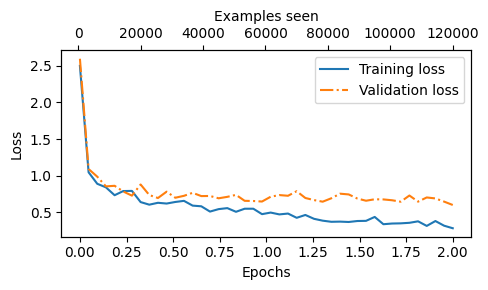

In [35]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)

In [36]:
torch.manual_seed(123)


for entry in test_data[1:4]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym for 'increase'?

Correct response:
>> An antonym for 'increase' is 'decrease'.

Model response:
>> An antonym for 'increase' is 'decrease'.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify this text as either a recipe or a novel.

### Input:
Combine flour, sugar, and eggs in a bowl.

Correct response:
>> Recipe

Model response:
>> A recipe for pancakes.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
rewrite this sentence as a question.

### Input:
Your brother went to London last year.

Correct response:
>> Did your brother go to London last year?

Model response:
>> What was your brother doing last year?
-------

In [ ]:
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     },
#     "model_and_optimizer.pth"
# )

## Save sft-llm

<div class="alert alert-block alert-warning">
<b>Data:</b> MMLU（"Measuring Massive Multitask Lanuage Understanding"）

学科范围 ：57个不同领域，包括：
STEM （数学、物理、化学、计算机等）
人文社科 （历史、法律、哲学、心理学等）
应用领域 （医学、工程、商业等）
日常知识 （食品营养、旅行规划等）
</div>

In [48]:
import re 
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth" #[]表示字符集合，匹配其中任意一个字符, 替换成''
# re.sub(pattern, replacement, string)

torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth
